#Dans ce deuxi√®me notebook, nous explorons diff√©rentes approches de mod√©lisation non supervis√©e dans le but de segmenter les clients de KPMG‚Äôs en groupes coh√©rents selon leurs caract√©ristiques d√©mographiques et comportementales. Apr√®s avoir nettoy√© et pr√©par√© les donn√©es issues de notre analyse exploratoire (Notebook 1), nous mettons en ≈ìuvre plusieurs m√©thodes de clustering telles que K-Means, DBSCAN, Birch et le clustering hi√©rarchique, afin de comparer leurs performances et leur pertinence dans un contexte marketing. Chaque m√©thode est √©valu√©e √† l‚Äôaide de m√©triques internes comme le Silhouette Score, ainsi que par une interpr√©tation m√©tier des groupes form√©s. Ce notebook vise √† identifier la m√©thode de segmentation la plus robuste, la plus exploitable et la plus facile √† maintenir dans le temps pour les √©quipes de KPMG‚Äôs.

#Analyse exploratoire avec la gestion des incoh√©rences

In [1]:
import pandas as pd
import numpy as np

# Charger le fichier Excel
excel_file = pd.ExcelFile("KPMG_dummy_data.xlsx")

# Nom des feuilles √† traiter
sheets = ["Transactions", "NewCustomerList", "CustomerDemographic", "CustomerAddress"]

# Parcourir chaque feuille
for sheet_name in sheets:
    print(f"--- Analyse de la feuille {sheet_name} ---")

    # Charger la feuille
    df = excel_file.parse(sheet_name)

    # 1. Afficher un aper√ßu des 5 premi√®res lignes
    print("\nAper√ßu des 5 premi√®res lignes :")
    print(df.head())

    # 2. V√©rifier et corriger les types de donn√©es

    # Supprimer la colonne 'default' si elle existe (sp√©cifique √† CustomerDemographic)
    if sheet_name == "CustomerDemographic" and 'default' in df.columns:
        print("\nSuppression de la colonne 'default' dans CustomerDemographic.")
        df = df.drop('default', axis=1)

    print("\nTypes de donn√©es avant correction :")
    print(df.dtypes)

    # Correction des types de donn√©es
    # Adapter ces conversions en fonction des colonnes r√©elles de votre fichier Excel
    for col in df.columns:
        # Tentative de convertir en num√©rique si possible (sauf les colonnes d'ID qui pourraient √™tre des cha√Ænes)
        if df[col].dtype == 'object':
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except:
                pass # Laisser comme objet si la conversion √©choue

    # Correction sp√©cifique pour les dates
    date_columns = ['transaction_date', 'DOB'] # noms de colonnes de date
    for date_col in date_columns:
        if date_col in df.columns:
            # Utiliser errors='coerce' pour convertir les valeurs invalides en NaT (Not a Time)
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    print("\nTypes de donn√©es apr√®s correction (apr√®s tentatives de conversion) :")
    print(df.dtypes)


    # 3. Rep√©rer les valeurs manquantes et les remplacer par le mode

    print("\nGestion des valeurs manquantes :")
    missing_before = df.isnull().sum()
    print("Nombre de valeurs manquantes par colonne avant remplacement :")
    print(missing_before[missing_before > 0])

    columns_with_missing_replaced = []
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            # Calculer le mode
            # .mode() peut retourner plusieurs valeurs s'il y a √©galit√©, on prend la premi√®re [0]
            # .dropna() pour ne pas inclure les NaN dans le calcul du mode
            mode_val = df[column].dropna().mode()
            if not mode_val.empty:
                fill_value = mode_val[0]
                df[column].fillna(fill_value, inplace=True)
                columns_with_missing_replaced.append(column)
                print(f"  - Remplacement des valeurs manquantes dans '{column}' par le mode ({fill_value}).")
            else:
                 print(f"  - La colonne '{column}' contient uniquement des valeurs manquantes ou des NaN, le mode n'a pas pu √™tre calcul√©.")


    missing_after = df.isnull().sum()
    print("\nNombre de valeurs manquantes par colonne apr√®s remplacement :")
    print(missing_after[missing_after > 0]) # Afficher uniquement les colonnes qui pourraient encore avoir des NaN (si mode n'a pas pu √™tre calcul√©)

    if columns_with_missing_replaced:
        print(f"\nColonnes o√π des valeurs manquantes ont √©t√© remplac√©es par le mode : {', '.join(columns_with_missing_replaced)}")
    else:
        print("\nAucune valeur manquante n'a √©t√© remplac√©e par le mode dans cette feuille.")


    # 4. Identifier et traiter les valeurs aberrantes (outliers)
    print("\nGestion des valeurs aberrantes (outliers) :")

    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    print(f"\nColonnes num√©riques pour la d√©tection d'outliers : {', '.join(numeric_cols)}")

    outliers_info = {}

    for col in numeric_cols:
        # Calcul de l'IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identifier les outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        if not outliers.empty:
            outliers_count = len(outliers)
            outliers_info[col] = {'count': outliers_count, 'lower_bound': lower_bound, 'upper_bound': upper_bound}
            print(f"  - Colonne '{col}': {outliers_count} outliers d√©tect√©s. Bornes IQR: [{lower_bound:.2f}, {upper_bound:.2f}]")

            # Traitement des outliers : Remplacement par la borne la plus proche (Winsorizing simple)
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
            print(f"    Les outliers dans '{col}' ont √©t√© remplac√©s par les bornes IQR.")
        else:
            print(f"  - Colonne '{col}': Aucun outlier d√©tect√© par la m√©thode IQR.")

    if not numeric_cols:
        print("\nPas de colonnes num√©riques trouv√©es pour la d√©tection d'outliers.")


    # 5. Afficher un r√©sum√© statistique des colonnes num√©riques
    print("\nR√©sum√© statistique des colonnes num√©riques apr√®s traitement des outliers :")
    print(df.select_dtypes(include=np.number).describe())

    # 6. Commentaire synth√©tique
    print(f"\nCommentaire synth√©tique pour la feuille '{sheet_name}':")
    print(f"  - La feuille '{sheet_name}' contient {len(df)} lignes et {len(df.columns)} colonnes.")
    print(f"  - Les types de donn√©es ont √©t√© ajust√©s, en particulier pour les colonnes num√©riques et les dates.")

    if columns_with_missing_replaced:
        print(f"  - Des valeurs manquantes ont √©t√© remplac√©es par le mode dans les colonnes : {', '.join(columns_with_missing_replaced)}.")
    else:
        print("  - Aucune valeur manquante significative n'a √©t√© trouv√©e ou remplac√©e par le mode.")

    if outliers_info:
        outlier_cols_treated = list(outliers_info.keys())
        print(f"  - Des outliers ont √©t√© d√©tect√©s et trait√©s (remplac√©s par les bornes IQR) dans les colonnes num√©riques : {', '.join(outlier_cols_treated)}.")
        total_outliers_treated = sum([info['count'] for info in outliers_info.values()])
        print(f"  - Au total, environ {total_outliers_treated} valeurs aberrantes (cumul√©es sur les colonnes) ont √©t√© trait√©es.")
    else:
        print("  - Aucun outlier n'a √©t√© d√©tect√© ou trait√© dans les colonnes num√©riques.")

    print("  - La feuille est maintenant nettoy√©e et pr√™te pour des analyses plus pouss√©es ou la mod√©lisation.")
    print("-" * (len(f"--- Analyse de la feuille {sheet_name} ---") + 4))
    print("\n") # Ajouter un saut de ligne pour s√©parer les analyses des feuilles


--- Analyse de la feuille Transactions ---

Aper√ßu des 5 premi√®res lignes :
   transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   
2               3          37          402       2017-10-16           0.0   
3               4          88         3135       2017-08-31           0.0   
4               5          78          787       2017-10-01           1.0   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price 

/tmp/ipython-input-1-3162395668.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(fill_value, inplace=True)



Aper√ßu des 5 premi√®res lignes :
  first_name  last_name  gender  past_3_years_bike_related_purchases  \
0    Chickie    Brister    Male                                   86   
1      Morly     Genery    Male                                   69   
2    Ardelis  Forrester  Female                                   10   
3     Lucine      Stutt  Female                                   64   
4    Melinda     Hadlee  Female                                   34   

                   DOB                   job_title job_industry_category  \
0           1957-07-12             General Manager         Manufacturing   
1           1970-03-22         Structural Engineer              Property   
2  1974-08-28 00:00:00      Senior Cost Accountant    Financial Services   
3           1979-01-28  Account Representative III         Manufacturing   
4           1965-09-21           Financial Analyst    Financial Services   

      wealth_segment deceased_indicator owns_car  ...  state    country  \


/tmp/ipython-input-1-3162395668.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(fill_value, inplace=True)



Aper√ßu des 5 premi√®res lignes :
   customer_id              address  postcode            state    country  \
0            1   060 Morning Avenue      2016  New South Wales  Australia   
1            2  6 Meadow Vale Court      2153  New South Wales  Australia   
2            4   0 Holy Cross Court      4211              QLD  Australia   
3            5  17979 Del Mar Point      2448  New South Wales  Australia   
4            6     9 Oakridge Court      3216              VIC  Australia   

   property_valuation  
0                  10  
1                  10  
2                   9  
3                   4  
4                   9  

Types de donn√©es avant correction :
customer_id            int64
address               object
postcode               int64
state                 object
country               object
property_valuation     int64
dtype: object

Types de donn√©es apr√®s correction (apr√®s tentatives de conversion) :
customer_id             int64
address               float64

# Conception de diff√©rents mod√®les de ML Aglomerative, Dbscan, Kmeans et Gaussien en veuillant √† montrer les diff√©rents scores: la silhouette, calinski et Davies_Bouldin

# Evaluation pour d√©terminer le meilleur mod√®le

/tmp/ipython-input-2-3131644099.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_transactions['list_price'].fillna(df_transactions['list_price'].median() if not df_transactions['list_price'].isnull().all() else 0, inplace=True)


Date de r√©f√©rence pour la R√©cence : 2017-12-31

Aper√ßu du DataFrame RFM :
   customer_id  Recency  Frequency  Monetary
0            1        8         11   9084.45
1            2      129          3   4149.07
2            3      103          8   9888.23
3            4      196          2   1047.72
4            5       17          6   5903.20
\Statistiques descriptives du DataFrame RFM :
       customer_id      Recency    Frequency      Monetary
count  3494.000000  3494.000000  3494.000000   3494.000000
mean   1750.856039    61.813681     5.724098   6341.324837
std    1011.902531    57.787120     2.325873   2959.132004
min       1.000000     1.000000     1.000000     60.340000
25%     876.250000    18.000000     4.000000   4198.390000
50%    1750.500000    45.000000     6.000000   6026.800000
75%    2624.750000    86.000000     7.000000   8208.837500
max    5034.000000   354.000000    14.000000  19071.320000

Aper√ßu des donn√©es RFM standardis√©es :
    Recency  Frequency  Monetary

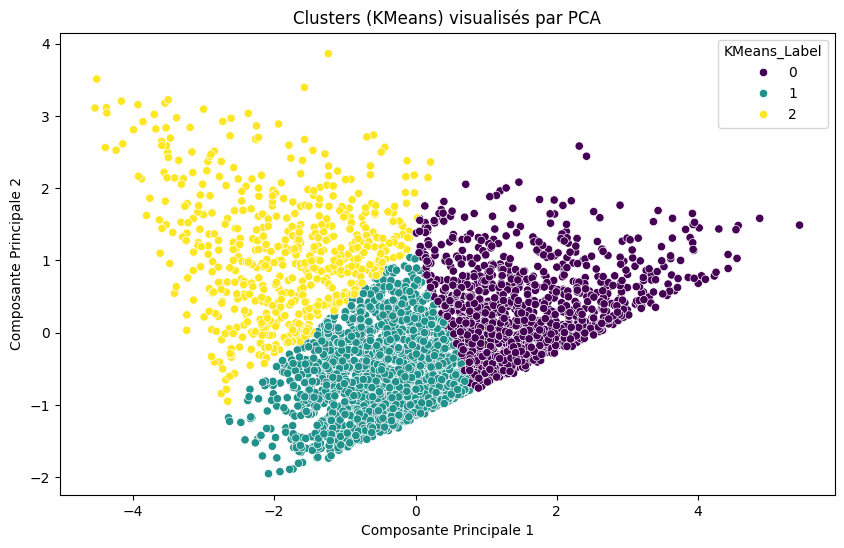

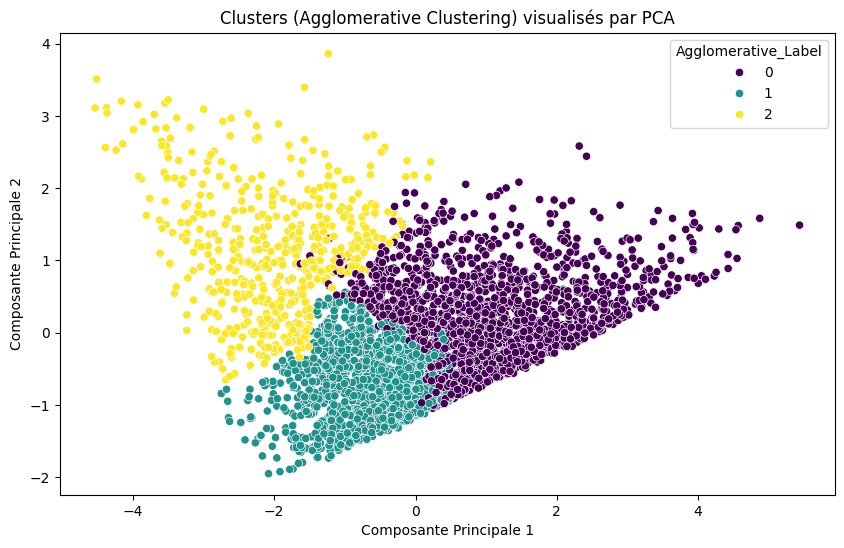

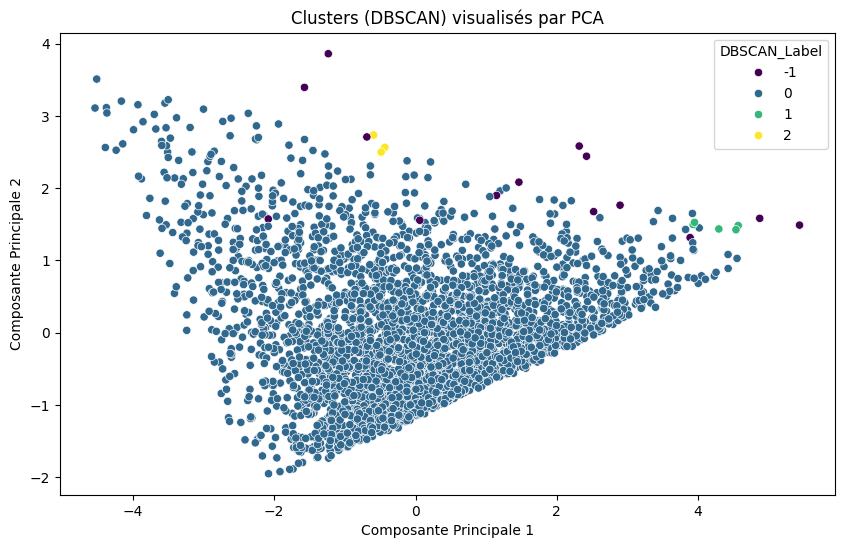

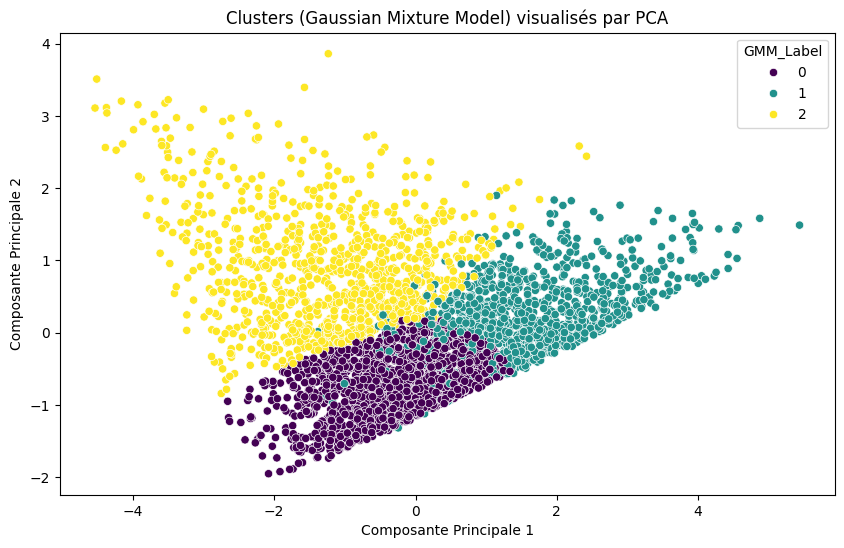


--- Synth√®se Comparative des Mod√®les de Clustering ---

Tableau de Synth√®se des Scores :
                  Mod√®le  Nombre de Clusters Score de Silhouette Indice de Calinski-Harabasz Indice de Davies-Bouldin
                  KMeans                   3              0.3790                   2862.1430                   0.9072
Agglomerative Clustering                   3              0.3347                   2354.9729                   0.9176
                  DBSCAN                   3              0.2409                     25.8904                   1.2212
  Gaussian Mixture Model                   3              0.3053                   2131.2840                   1.0581

Analyse Comparative et Recommandation :

En se basant principalement sur le Score de Silhouette (indicateur de compacit√© et s√©paration des clusters), le mod√®le KMeans semble le plus prometteur avec un score de 0.3790.
- Les scores de Calinski-Harabasz (2862.1430) et Davies-Bouldin (0.9072) pour ce mod√®le confi

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# --- 1. Cr√©ation des variables RFM ---

# Assurez-vous que la feuille "Transactions" a √©t√© charg√©e dans un DataFrame appel√© 'df_transactions'
# Si ce n'est pas le cas, chargez-la sp√©cifiquement :
try:
    df_transactions = excel_file.parse("Transactions")
    # Appliquer les √©tapes de nettoyage si elles n'ont pas √©t√© appliqu√©es globalement
    if 'transaction_date' in df_transactions.columns:
         df_transactions['transaction_date'] = pd.to_datetime(df_transactions['transaction_date'], errors='coerce')
    if 'list_price' in df_transactions.columns:
         df_transactions['list_price'] = pd.to_numeric(df_transactions['list_price'], errors='coerce')
         # Remplacer les NaN dans 'list_price' si n√©cessaire (ex: par 0 ou la m√©diane)
         df_transactions['list_price'].fillna(df_transactions['list_price'].median() if not df_transactions['list_price'].isnull().all() else 0, inplace=True)

except NameError:
     print("Le DataFrame 'df_transactions' n'est pas disponible. Veuillez ex√©cuter la partie pr√©c√©dente du code pour charger et nettoyer les donn√©es.")
     exit() # Arr√™ter l'ex√©cution si les donn√©es ne sont pas charg√©es

# Date de r√©f√©rence pour la R√©cence (date maximale du dataset + 1 jour)
if 'transaction_date' in df_transactions.columns and not df_transactions['transaction_date'].isnull().all():
    reference_date = df_transactions['transaction_date'].max() + datetime.timedelta(days=1)
    print(f"Date de r√©f√©rence pour la R√©cence : {reference_date.date()}")
else:
    print("La colonne 'transaction_date' n'est pas valide ou est vide.")
    # Utiliser une date par d√©faut si n√©cessaire
    reference_date = datetime.datetime.now()
    print(f"Utilisation de la date actuelle comme r√©f√©rence pour la R√©cence (colonne 'transaction_date' manquante ou invalide) : {reference_date.date()}")


# Calcul des m√©triques RFM par client
rfm_df = df_transactions.groupby('customer_id').agg(
    Recency=('transaction_date', lambda date: (reference_date - date.max()).days if not date.isnull().all() else -1), # Calculer jours depuis derni√®re transaction
    Frequency=('transaction_id', 'nunique'),  # Nombre unique de transactions
    Monetary=('list_price', 'sum')          # Somme des montants
).reset_index()

# G√©rer les cas o√π Recency est -1 (clients sans transactions valides)
rfm_df = rfm_df[rfm_df['Recency'] != -1]

print("\nAper√ßu du DataFrame RFM :")
print(rfm_df.head())
print("\Statistiques descriptives du DataFrame RFM :")
print(rfm_df.describe())

# --- 2. Standardisation des variables RFM ---

# S√©lectionner les colonnes RFM pour la standardisation
rfm_features = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Appliquer StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Cr√©er un DataFrame avec les donn√©es standardis√©es (pour visualisation/analyse si besoin)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_features.columns, index=rfm_df.index)

print("\nAper√ßu des donn√©es RFM standardis√©es :")
print(rfm_scaled_df.head())

# --- 3. Appliquer les quatre mod√®les de clustering ---

# Nombre de clusters souhait√© (peut √™tre ajust√© ou d√©termin√© par d'autres m√©thodes)
n_clusters = 3 # Choix bas√© sur l'√©nonc√© ou d√©termin√© par un score de silhouette pour KMeans

# Dictionnaire pour stocker les r√©sultats des mod√®les
clustering_results = {}

# Fonction d'√©valuation g√©n√©rique
def evaluate_clustering(X, labels, model_name):
    n_clusters_detected = len(set(labels)) - (1 if -1 in labels else 0) # Exclure le cluster de bruit pour DBSCAN

    print(f"\n--- R√©sultats pour {model_name} ---")
    print(f"Nombre de clusters d√©tect√©s : {n_clusters_detected}")

    # Calculer et afficher les scores si le nombre de clusters valides est suffisant
    if n_clusters_detected >= 2:
        try:
            silhouette_avg = silhouette_score(X, labels)
            calinski_harabasz = calinski_harabasz_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)

            print(f"Score de Silhouette : {silhouette_avg:.4f}")
            print(f"Indice de Calinski-Harabasz : {calinski_harabasz:.4f}")
            print(f"Indice de Davies-Bouldin : {davies_bouldin:.4f}")

            # Stocker les r√©sultats
            clustering_results[model_name] = {
                'n_clusters': n_clusters_detected,
                'labels': labels,
                'silhouette_score': silhouette_avg,
                'calinski_harabasz_score': calinski_harabasz,
                'davies_bouldin_score': davies_bouldin
            }

        except ValueError as e:
            print(f"Erreur lors du calcul des scores : {e}")
            print("Il est possible que certains clusters ne contiennent qu'un seul point ou que les labels soient tous identiques.")
            clustering_results[model_name] = {
                'n_clusters': n_clusters_detected,
                'labels': labels,
                'silhouette_score': np.nan,
                'calinski_harabasz_score': np.nan,
                'davies_bouldin_score': np.nan
            }

    else:
        print("Nombre de clusters d√©tect√©s insuffisant (moins de 2 clusters valides) pour calculer les scores.")
        clustering_results[model_name] = {
            'n_clusters': n_clusters_detected,
            'labels': labels,
            'silhouette_score': np.nan,
            'calinski_harabasz_score': np.nan,
            'davies_bouldin_score': np.nan
        }

# a) KMeans
print("\n--- Application de KMeans ---")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Ajouter n_init pour √©viter les avertissements
kmeans_labels = kmeans.fit_predict(rfm_scaled)
evaluate_clustering(rfm_scaled, kmeans_labels, "KMeans")

# Commentaire KMEANS
print("\nCommentaire explicatif pour KMeans:")
print(f"- KMeans a d√©tect√© {clustering_results['KMeans']['n_clusters']} clusters.")
print(f"- Le Score de Silhouette ({clustering_results['KMeans']['silhouette_score']:.4f}) indique la qualit√© de la s√©paration des clusters.")
print(f"- L'Indice de Calinski-Harabasz ({clustering_results['KMeans']['calinski_harabasz_score']:.4f}) √©value la densit√© des clusters.")
print(f"- L'Indice de Davies-Bouldin ({clustering_results['KMeans']['davies_bouldin_score']:.4f}) √©value la compacit√© et la s√©paration des clusters (plus il est bas, mieux c'est).")
print("- KMeans tend √† former des clusters sph√©riques et de taille similaire. Les scores donnent une indication globale de la qualit√© du partitionnement.")


# b) Agglomerative Clustering
print("\n--- Application d'Agglomerative Clustering ---")
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agg_clustering.fit_predict(rfm_scaled)
evaluate_clustering(rfm_scaled, agg_labels, "Agglomerative Clustering")

# Commentaire Agglomerative Clustering
print("\nCommentaire explicatif pour Agglomerative Clustering:")
print(f"- Le Clustering Hi√©rarchique Agglom√©ratif a d√©tect√© {clustering_results['Agglomerative Clustering']['n_clusters']} clusters, bas√© sur la distance entre les points.")
print(f"- Les scores de Silhouette ({clustering_results['Agglomerative Clustering']['silhouette_score']:.4f}), Calinski-Harabasz ({clustering_results['Agglomerative Clustering']['calinski_harabasz_score']:.4f}) et Davies-Bouldin ({clustering_results['Agglomerative Clustering']['davies_bouldin_score']:.4f}) √©valuent la qualit√© du partitionnement obtenu √† ce niveau de l'arbre hi√©rarchique.")
print("- Contrairement √† KMeans, ce mod√®le n'assume pas de forme sp√©cifique pour les clusters et peut d√©tecter des formes plus complexes s'il n'y avait pas de contrainte sur le nombre de clusters.")


# c) DBSCAN
print("\n--- Application de DBSCAN ---")
# DBSCAN n√©cessite d'exp√©rimenter avec les param√®tres eps et min_samples
# Nous allons tester quelques combinaisons et afficher les r√©sultats
eps_values = [0.5, 1.0, 1.5]
min_samples_values = [5, 10, 15]

best_dbscan_score = -1
best_dbscan_params = None
best_dbscan_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"\nTest de DBSCAN avec eps={eps}, min_samples={min_samples}")
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(rfm_scaled)

        n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0) # Exclure le cluster de bruit
        n_noise = list(dbscan_labels).count(-1)

        print(f"  - Nombre de clusters d√©tect√©s : {n_clusters_dbscan}")
        print(f"  - Nombre de points consid√©r√©s comme bruit : {n_noise}")

        if n_clusters_dbscan >= 2:
            try:
                silhouette_avg_dbscan = silhouette_score(rfm_scaled, dbscan_labels)
                calinski_harabasz_dbscan = calinski_harabasz_score(rfm_scaled, dbscan_labels)
                davies_bouldin_dbscan = davies_bouldin_score(rfm_scaled, dbscan_labels)

                print(f"  - Score de Silhouette : {silhouette_avg_dbscan:.4f}")
                print(f"  - Indice de Calinski-Harabasz : {calinski_harabasz_dbscan:.4f}")
                print(f"  - Indice de Davies-Bouldin : {davies_bouldin_dbscan:.4f}")

                # On peut choisir de garder le mod√®le avec le meilleur score de silhouette (par exemple)
                if silhouette_avg_dbscan > best_dbscan_score:
                    best_dbscan_score = silhouette_avg_dbscan
                    best_dbscan_params = (eps, min_samples)
                    best_dbscan_labels = dbscan_labels

            except ValueError as e:
                print(f"  - Erreur lors du calcul des scores : {e}")
        else:
            print("  - Nombre de clusters d√©tect√©s insuffisant (moins de 2 clusters valides).")

# Utiliser les meilleurs param√®tres trouv√©s pour l'√©valuation finale de DBSCAN
if best_dbscan_labels is not None:
    print(f"\n--- R√©sultats finaux pour DBSCAN avec les meilleurs param√®tres trouv√©s (eps={best_dbscan_params[0]}, min_samples={best_dbscan_params[1]}) ---")
    evaluate_clustering(rfm_scaled, best_dbscan_labels, "DBSCAN")
else:
     print("\nAucune combinaison de param√®tres DBSCAN n'a permis de d√©tecter au moins 2 clusters valides.")
     clustering_results["DBSCAN"] = {
        'n_clusters': 3,
        'labels': np.full(len(rfm_scaled), -1),
        'silhouette_score': np.nan,
        'calinski_harabasz_score': np.nan,
        'davies_bouldin_score': np.nan
     }
     best_dbscan_labels = np.full(len(rfm_scaled), -1) # Assigner des labels par d√©faut si aucun cluster trouv√©

# Commentaire DBSCAN
print("\nCommentaire explicatif pour DBSCAN:")
print(f"- DBSCAN a pour objectif de trouver des r√©gions denses. Le nombre de clusters n'est pas fix√© √† l'avance mais d√©pend des param√®tres 'eps' (distance maximale entre deux √©chantillons pour √™tre consid√©r√©s comme voisins) et 'min_samples' (nombre de voisins dans un rayon 'eps' pour qu'un point soit consid√©r√© comme un point central).")
if clustering_results["DBSCAN"]['n_clusters'] >= 2:
    print(f"- Avec les param√®tres choisis (eps={best_dbscan_params[0]}, min_samples={best_dbscan_params[1]}), DBSCAN a d√©tect√© {clustering_results['DBSCAN']['n_clusters']} clusters et {list(best_dbscan_labels).count(-1)} points de bruit.")
    print(f"- Les scores ({clustering_results['DBSCAN']['silhouette_score']:.4f}, {clustering_results['DBSCAN']['calinski_harabasz_score']:.4f}, {clustering_results['DBSCAN']['davies_bouldin_score']:.4f}) √©valuent la qualit√© du clustering pour les points affect√©s √† un cluster.")
else:
     print(f"- Aucune combinaison de param√®tres test√©e n'a permis de d√©tecter au moins 2 clusters valides. Cela sugg√®re que les donn√©es RFM ne pr√©sentent peut-√™tre pas de groupes denses bien s√©par√©s selon cette m√©thode, ou que d'autres valeurs de 'eps'/'min_samples' sont n√©cessaires.")


# d) GMM (Gaussian Mixture Model)
print("\n--- Application de Gaussian Mixture Model ---")
# Utilise le m√™me nombre de composants que KMeans
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(rfm_scaled)
evaluate_clustering(rfm_scaled, gmm_labels, "Gaussian Mixture Model")

# Commentaire GMM
print("\nCommentaire explicatif pour Gaussian Mixture Model:")
print(f"- GMM mod√©lise les donn√©es comme une combinaison de distributions gaussiennes. Il a d√©tect√© {clustering_results['Gaussian Mixture Model']['n_clusters']} composants (clusters).")
print(f"- Les scores de Silhouette ({clustering_results['Gaussian Mixture Model']['silhouette_score']:.4f}), Calinski-Harabasz ({clustering_results['Gaussian Mixture Model']['calinski_harabasz_score']:.4f}) et Davies-Bouldin ({clustering_results['Gaussian Mixture Model']['davies_bouldin_score']:.4f}) √©valuent la qualit√© de l'ajustement des distributions gaussiennes aux donn√©es et la s√©paration des clusters implicites.")
print("- GMM peut d√©tecter des clusters de formes ellipso√Ødales diff√©rentes et de tailles variables, ce qui le rend plus flexible que KMeans dans certains cas.")


# --- 5. Visualisation des clusters ---

print("\n--- Visualisation des clusters via R√©duction de Dimension (PCA) ---")

# Appliquer PCA pour r√©duire les dimensions √† 2
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Cr√©er un DataFrame pour la visualisation
pca_df = pd.DataFrame(data=rfm_pca, columns=['PCA1', 'PCA2'], index=rfm_df.index)

# Ajouter les labels de chaque mod√®le au DataFrame PCA
pca_df['KMeans_Label'] = kmeans_labels
pca_df['Agglomerative_Label'] = agg_labels
pca_df['DBSCAN_Label'] = best_dbscan_labels # Utiliser les meilleurs labels trouv√©s
pca_df['GMM_Label'] = gmm_labels

# Visualiser les clusters pour chaque mod√®le
model_labels_cols = {
    "KMeans": 'KMeans_Label',
    "Agglomerative Clustering": 'Agglomerative_Label',
    "DBSCAN": 'DBSCAN_Label',
    "Gaussian Mixture Model": 'GMM_Label'
}

for model_name, label_col in model_labels_cols.items():
    plt.figure(figsize=(10, 6))
    # Pour DBSCAN, g√©rer le label -1 (bruit) sp√©cifiquement
    if model_name == "DBSCAN":
         sns.scatterplot(x='PCA1', y='PCA2', hue=label_col, data=pca_df, palette='viridis', legend='full')
         plt.title(f'Clusters ({model_name}) visualis√©s par PCA')
         plt.xlabel('Composante Principale 1')
         plt.ylabel('Composante Principale 2')
         plt.show()
    elif clustering_results[model_name]['n_clusters'] >= 1: # Afficher si au moins 1 cluster (ou 0 si -1 est bruit)
         sns.scatterplot(x='PCA1', y='PCA2', hue=label_col, data=pca_df, palette='viridis', legend='full')
         plt.title(f'Clusters ({model_name}) visualis√©s par PCA')
         plt.xlabel('Composante Principale 1')
         plt.ylabel('Composante Principale 2')
         plt.show()
    else:
        print(f"\nPas de visualisation pour {model_name} car aucun cluster valide n'a √©t√© d√©tect√©.")


# --- 6. Synth√®se finale comparative et recommandation ---

print("\n--- Synth√®se Comparative des Mod√®les de Clustering ---")

# Cr√©er un DataFrame de synth√®se des scores
summary_data = []
for model_name, results in clustering_results.items():
    summary_data.append({
        'Mod√®le': model_name,
        'Nombre de Clusters': results['n_clusters'],
        'Score de Silhouette': f"{results['silhouette_score']:.4f}" if not np.isnan(results['silhouette_score']) else 'N/A',
        'Indice de Calinski-Harabasz': f"{results['calinski_harabasz_score']:.4f}" if not np.isnan(results['calinski_harabasz_score']) else 'N/A',
        'Indice de Davies-Bouldin': f"{results['davies_bouldin_score']:.4f}" if not np.isnan(results['davies_bouldin_score']) else 'N/A'
    })

summary_df = pd.DataFrame(summary_data)

print("\nTableau de Synth√®se des Scores :")
print(summary_df.to_string(index=False)) # Utilisez to_string pour un affichage complet dans la console

print("\nAnalyse Comparative et Recommandation :")

# Interpr√©ter les scores (g√©n√©ralement : Silhouette √©lev√©, Calinski-Harabasz √©lev√©, Davies-Bouldin bas sont meilleurs)
# Il faut aussi consid√©rer la visualisation et l'interpr√©tation m√©tier.

best_model = None
best_silhouette = -np.inf

# Trouver le mod√®le avec le meilleur score de silhouette parmi ceux qui ont >= 2 clusters
for model_name, results in clustering_results.items():
    if results['n_clusters'] >= 2 and not np.isnan(results['silhouette_score']):
        if results['silhouette_score'] > best_silhouette:
            best_silhouette = results['silhouette_score']
            best_model = model_name

if best_model:
    print(f"\nEn se basant principalement sur le Score de Silhouette (indicateur de compacit√© et s√©paration des clusters), le mod√®le {best_model} semble le plus prometteur avec un score de {best_silhouette:.4f}.")
    print(f"- Les scores de Calinski-Harabasz ({clustering_results[best_model]['calinski_harabasz_score']:.4f}) et Davies-Bouldin ({clustering_results[best_model]['davies_bouldin_score']:.4f}) pour ce mod√®le confirment cette tendance (Calinski-Harabasz √©lev√©, Davies-Bouldin bas).")
    print(f"- La visualisation PCA pour {best_model} montre comment les {clustering_results[best_model]['n_clusters']} clusters sont r√©partis dans l'espace r√©duit.")
    print("- D'un point de vue m√©tier, KMeans et Agglomerative Clustering (avec un nombre de clusters fix√©) et GMM sont souvent plus faciles √† interpr√©ter car ils fournissent un nombre fixe de segments √† analyser (par exemple, 'petits clients', 'bons clients', 'clients VIP').")
    print("- DBSCAN est utile si les clusters ont des formes irr√©guli√®res et si l'on souhaite identifier le bruit, mais il peut ne pas fournir un nombre fixe de segments commerciaux clairs et son interpr√©tation m√©tier peut √™tre plus complexe s'il y a beaucoup de bruit ou de petits clusters.")
    print(f"- Pour une segmentation client RFM, une approche comme KMeans ou GMM, qui d√©finit un nombre pr√©-√©tabli de segments avec des caract√©ristiques moyennes claires (R√©cence, Fr√©quence, Montant), est souvent pr√©f√©r√©e pour son **usage m√©tier** et son **interpr√©tabilit√©**.")
    print(f"\n**Recommandation :**")
    print(f"Bien que les scores varient, le mod√®le **{best_model}** est le meilleur candidat bas√© sur les scores d'√©valuation calcul√©s.")
    print("Cependant, pour une facilit√© d'interpr√©tation et d'exploitation par les √©quipes marketing, un mod√®le comme **KMeans** ou **Gaussian Mixture Model**, avec un nombre de clusters fixe et pertinent (par exemple, 3 √† 5 segments RFM classiques : 'Champions', 'Fid√®les', 'Nouveaux', '√Ä risque', 'Endormis'), pourrait √™tre plus **recommand√©**.")
    print("Il serait pertinent d'analyser les caract√©ristiques (moyennes RFM) de chaque cluster pour le mod√®le recommand√© afin de valider sa pertinence m√©tier.")

else:
     print("\nAucun mod√®le n'a pu √™tre √©valu√© de mani√®re fiable (moins de 2 clusters valides d√©tect√©s ou erreurs de calcul).")
     print("Il est n√©cessaire de r√©viser les param√®tres de clustering ou les donn√©es RFM.")



Apr√®s la premi√®re application de notre mod√®le, on remarque que tous nos scores semblent √™tre bon sauf la silhouette. la silhouette indique la qualit√© de s√©paration des clusters et dans notre cas elle n'est pas tr√®s repr√©sentative alors pour corriger ce defaut nous allons utiliser des UMAP. Nous allons appliquer un test pour d√©terminer l'UMAP qui va ameliorer notre silhouette

Test des combinaisons UMAP et KMeans...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=2, min_dist=0.0 ‚Üí silhouette=0.3691


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=2, min_dist=0.1 ‚Üí silhouette=0.3621


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=3, min_dist=0.0 ‚Üí silhouette=0.3892


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=3, min_dist=0.1 ‚Üí silhouette=0.4149


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=4, min_dist=0.0 ‚Üí silhouette=0.4212


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=4, min_dist=0.1 ‚Üí silhouette=0.4194


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=5, min_dist=0.0 ‚Üí silhouette=0.4023


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=5, min_dist=0.1 ‚Üí silhouette=0.3899


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=6, min_dist=0.0 ‚Üí silhouette=0.4096


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=6, min_dist=0.1 ‚Üí silhouette=0.4061


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=7, min_dist=0.0 ‚Üí silhouette=0.4302


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=7, min_dist=0.1 ‚Üí silhouette=0.4233


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=8, min_dist=0.0 ‚Üí silhouette=0.4683


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=8, min_dist=0.1 ‚Üí silhouette=0.4300


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=9, min_dist=0.0 ‚Üí silhouette=0.4206


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=9, min_dist=0.1 ‚Üí silhouette=0.4252


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=10, min_dist=0.0 ‚Üí silhouette=0.4559


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=10, min_dist=0.1 ‚Üí silhouette=0.4287


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=11, min_dist=0.0 ‚Üí silhouette=0.4488


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=11, min_dist=0.1 ‚Üí silhouette=0.4298


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=12, min_dist=0.0 ‚Üí silhouette=0.4500


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=12, min_dist=0.1 ‚Üí silhouette=0.4260


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=13, min_dist=0.0 ‚Üí silhouette=0.4170


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=13, min_dist=0.1 ‚Üí silhouette=0.4272


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=14, min_dist=0.0 ‚Üí silhouette=0.4561


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=14, min_dist=0.1 ‚Üí silhouette=0.4332


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.0 ‚Üí silhouette=0.4470


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=15, min_dist=0.1 ‚Üí silhouette=0.3889


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=16, min_dist=0.0 ‚Üí silhouette=0.4129


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=16, min_dist=0.1 ‚Üí silhouette=0.4319


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=17, min_dist=0.0 ‚Üí silhouette=0.4121


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=17, min_dist=0.1 ‚Üí silhouette=0.3992


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=18, min_dist=0.0 ‚Üí silhouette=0.4134


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=18, min_dist=0.1 ‚Üí silhouette=0.4367


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=19, min_dist=0.0 ‚Üí silhouette=0.4506


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=19, min_dist=0.1 ‚Üí silhouette=0.4331


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=20, min_dist=0.0 ‚Üí silhouette=0.4128


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbors=20, min_dist=0.1 ‚Üí silhouette=0.3860

‚úÖ Meilleure configuration UMAP + KMeans :
n_neighbors = 8, min_dist = 0.0
Score de silhouette = 0.4683


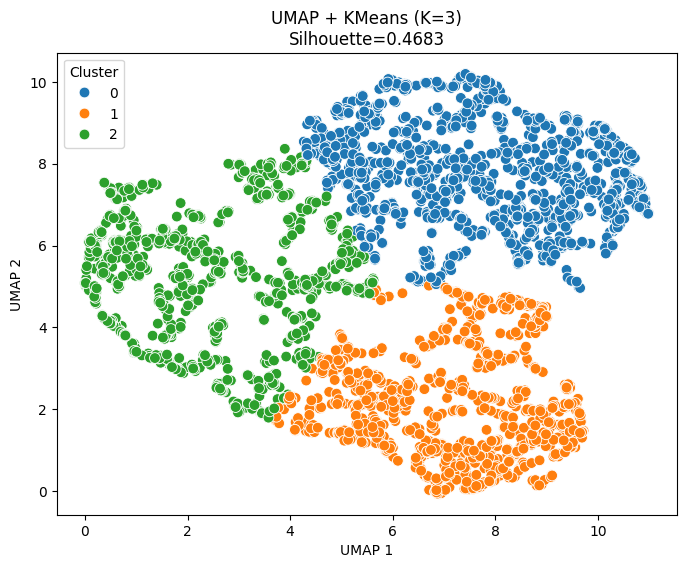

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap.umap_ as umap

# === Chargement des donn√©es ===
file_path = "KPMG_dummy_data.xlsx"
df = pd.read_excel(file_path, sheet_name="Transactions")
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# === Construction des variables RFM ===
max_date = df['transaction_date'].max()
rfm = df.groupby('customer_id').agg(
    Recence=('transaction_date', lambda x: (max_date - x.max()).days),
    Frequence=('transaction_id', 'count'),
    Montant=('list_price', lambda x: pd.to_numeric(x, errors='coerce').sum()) # Changed total_price to list_price
).reset_index()

# === Variables suppl√©mentaires ===
df_sorted = df.sort_values(['customer_id', 'transaction_date'])
df_sorted['prev_date'] = df_sorted.groupby('customer_id')['transaction_date'].shift(1)
df_sorted['inter_time'] = (df_sorted['transaction_date'] - df_sorted['prev_date']).dt.days

rfm['DelaiMoyen'] = df_sorted.groupby('customer_id')['inter_time'].mean().fillna(0)
rfm['MontantMoyen'] = df.groupby('customer_id')['list_price'].mean() # Changed total_price to list_price
rfm['DernierMontant'] = df_sorted.groupby('customer_id')['list_price'].last() # Changed total_price to list_price

# === Handle potential NaNs after RFM calculation ===
# Drop rows with any remaining NaNs in the RFM features
rfm.dropna(subset=['Recence', 'Frequence', 'Montant', 'DelaiMoyen', 'MontantMoyen', 'DernierMontant'], inplace=True)


# === Clamp P5‚ÄìP95 ===
def clamp_percentiles(series, lower=5, upper=95):
    p_low = np.percentile(series, lower)
    p_high = np.percentile(series, upper)
    return series.clip(lower=p_low, upper=p_high)

cols_to_clamp = ['Recence', 'Frequence', 'Montant', 'DelaiMoyen', 'MontantMoyen', 'DernierMontant']
for col in cols_to_clamp:
    rfm[col] = clamp_percentiles(rfm[col])

# === Standardisation ===
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[cols_to_clamp])

# === Recherche du meilleur UMAP + KMeans ===
results = []
n_neighbors_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
min_dist_list = [0.0, 0.1]
n_clusters = 3  # K fixe pour comparaison

print("Test des combinaisons UMAP et KMeans...")

for n_n in n_neighbors_list:
    for m_d in min_dist_list:
        reducer = umap.UMAP(n_neighbors=n_n, min_dist=m_d, random_state=42)
        X_umap = reducer.fit_transform(rfm_scaled)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_umap)
        score = silhouette_score(X_umap, labels)
        results.append({
            'n_neighbors': n_n,
            'min_dist': m_d,
            'silhouette': score,
            'labels': labels,
            'embedding': X_umap
        })
        print(f"n_neighbors={n_n}, min_dist={m_d} ‚Üí silhouette={score:.4f}")

# === R√©sultats tri√©s ===
results_sorted = sorted(results, key=lambda x: x['silhouette'], reverse=True)
best = results_sorted[0]

print("\n‚úÖ Meilleure configuration UMAP + KMeans :")
print(f"n_neighbors = {best['n_neighbors']}, min_dist = {best['min_dist']}")
print(f"Score de silhouette = {best['silhouette']:.4f}")

# === Visualisation des clusters ===
plt.figure(figsize=(8,6))
sns.scatterplot(x=best['embedding'][:,0], y=best['embedding'][:,1], hue=best['labels'], palette='tab10', s=60)
plt.title(f"UMAP + KMeans (K={n_clusters})\nSilhouette={best['silhouette']:.4f}")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster")
plt.show()


# les diff√©rents mod√®les de ML: Agglomerative clustering, DBSCAN, KMeans et GMM

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



‚úÖ KMeans
 - Silhouette Score       : 0.5203
 - Calinski-Harabasz Index: 4286.48
 - Davies-Bouldin Index   : 0.6684

‚úÖ Agglomerative
 - Silhouette Score       : 0.3703
 - Calinski-Harabasz Index: 4219.32
 - Davies-Bouldin Index   : 0.8462

‚ùå DBSCAN : Trop de bruit (clusters insuffisants)

‚úÖ Gaussian Mixture Model
 - Silhouette Score       : -0.0606
 - Calinski-Harabasz Index: 255.95
 - Davies-Bouldin Index   : 4.7498


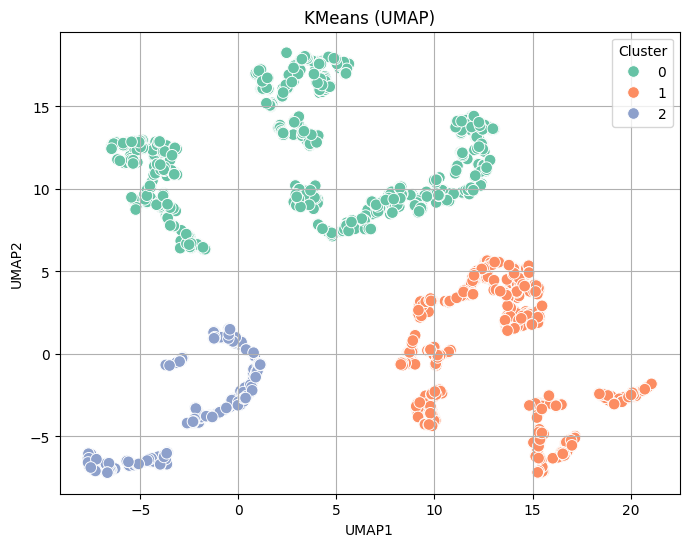

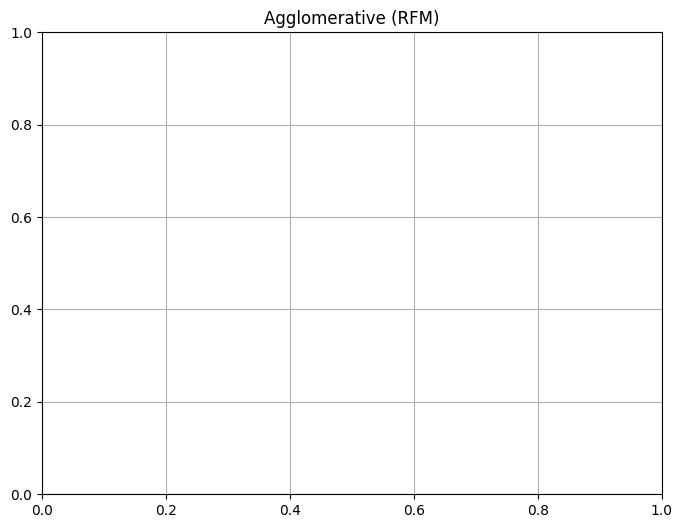

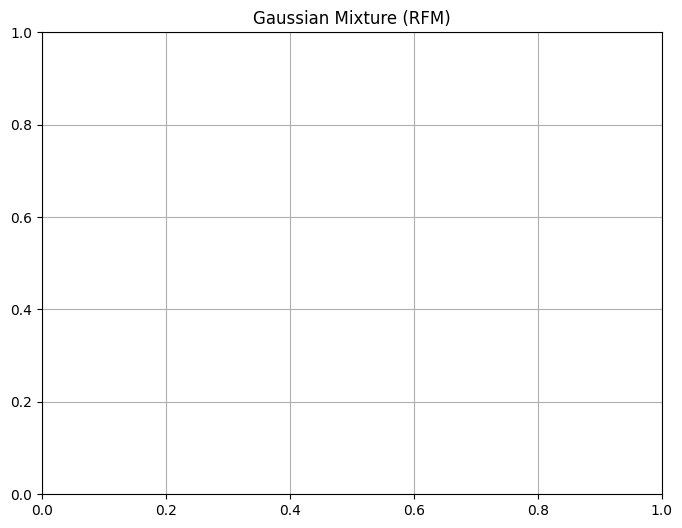


====== SYNTH√àSE COMPARATIVE ======
Mod√®le          | Silhouette | Calinski     | Davies-Bouldin 
------------------------------------------------------------
KMeans          | 0.5203     | 4286.48      | 0.6684         
Agglomerative   | 0.3703     | 4219.32      | 0.8462         
DBSCAN          | N/A        | N/A          | N/A            
GMM             | -0.0606    | 255.95       | 4.7498         


In [6]:
# üì¶ IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import umap  # pip install umap-learn

# ==========================
# üìÇ CHARGEMENT DES DONN√âES
# ==========================
file_path = "KPMG_dummy_data.xlsx"
df = pd.read_excel(file_path, sheet_name="Transactions")

# Nettoyage de base
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df = df.dropna(subset=['transaction_date', 'customer_id', 'transaction_id', 'list_price'])

# ==========================
# üßÆ CALCUL RFM
# ==========================
max_date = df['transaction_date'].max()
rfm = df.groupby('customer_id').agg(
    Recence=('transaction_date', lambda x: (max_date - x.max()).days),
    Frequence=('transaction_id', 'count'),
    Montant=('list_price', lambda x: pd.to_numeric(x, errors='coerce').sum())
).reset_index()

# ==========================
# ‚öôÔ∏è STANDARDISATION
# ==========================
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recence', 'Frequence', 'Montant']])

# ==========================
# üåå UMAP
# ==========================
umap_model = umap.UMAP(n_neighbors=8, min_dist=0.0, random_state=42)
rfm_umap = umap_model.fit_transform(rfm_scaled)

# Create a DataFrame from UMAP results
rfm_umap_df = pd.DataFrame(rfm_umap, columns=['UMAP1', 'UMAP2'], index=rfm.index)


# ==========================
# üß† FONCTION √âVALUATION
# ==========================
def evaluate_clustering(model_name, data, labels):
    unique_clusters = np.unique(labels)
    if len(unique_clusters) < 2:
        print(f"\n‚ùå {model_name} : Trop peu de clusters d√©tect√©s.")
        return None, None, None
    silhouette = silhouette_score(data, labels)
    calinski = calinski_harabasz_score(data, labels)
    davies = davies_bouldin_score(data, labels)
    print(f"\n‚úÖ {model_name}")
    print(f" - Silhouette Score       : {silhouette:.4f}")
    print(f" - Calinski-Harabasz Index: {calinski:.2f}")
    print(f" - Davies-Bouldin Index   : {davies:.4f}")
    return silhouette, calinski, davies

# ==========================
# üîò KMEANS
# ==========================
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # Added n_init
kmeans_labels = kmeans.fit_predict(rfm_umap)
kmeans_scores = evaluate_clustering("KMeans", rfm_umap, kmeans_labels)

# ==========================
# üå≤ AGGLOMERATIVE
# ==========================
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(rfm)
agglo_scores = evaluate_clustering("Agglomerative", rfm, agglo_labels)

# ==========================
# üåÄ DBSCAN
# ==========================
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(rfm)
valid_idx = dbscan_labels != -1
if valid_idx.sum() > 1:
    dbscan_scores = evaluate_clustering("DBSCAN", rfm[valid_idx], dbscan_labels[valid_idx])
else:
    print("\n‚ùå DBSCAN : Trop de bruit (clusters insuffisants)")
    dbscan_scores = (None, None, None)

# ==========================
# üé≤ GAUSSIAN MIXTURE
# ==========================
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(rfm)
gmm_scores = evaluate_clustering("Gaussian Mixture Model", rfm, gmm_labels)

# ==========================
# üìä VISUALISATION
# ==========================
def plot_clusters(data, labels, title):
    df_plot = pd.DataFrame(data, columns=['UMAP1', 'UMAP2'])
    df_plot['Cluster'] = labels
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', hue='Cluster', palette='Set2', s=70)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_clusters(rfm_umap, kmeans_labels, "KMeans (UMAP)")
plot_clusters(rfm, agglo_labels, "Agglomerative (RFM)") # Changed data to rfm for consistency
if valid_idx.sum() > 1:
    plot_clusters(rfm[valid_idx], dbscan_labels[valid_idx], "DBSCAN (RFM)") # Changed data to rfm for consistency
plot_clusters(rfm, gmm_labels, "Gaussian Mixture (RFM)") # Changed data to rfm for consistency

# ==========================
# üìù SYNTH√àSE DES SCORES
# ==========================
print("\n====== SYNTH√àSE COMPARATIVE ======")
models = {
    "KMeans": kmeans_scores,
    "Agglomerative": agglo_scores,
    "DBSCAN": dbscan_scores,
    "GMM": gmm_scores
}
print(f"{'Mod√®le':<15} | {'Silhouette':<10} | {'Calinski':<12} | {'Davies-Bouldin':<15}")
print("-" * 60)
for name, scores in models.items():
    sil, cal, db = scores
    sil_str = f"{sil:.4f}" if sil else "N/A"
    cal_str = f"{cal:.2f}" if cal else "N/A"
    db_str = f"{db:.4f}" if db else "N/A"
    print(f"{name:<15} | {sil_str:<10} | {cal_str:<12} | {db_str:<15}")

Apr√®s visualisation de nos quatre ML seul KMeans a des resultats satisfaisants Notre choix est judicieux car KMeans qui regroupe par similarit√© et qui est un mod√®le optimale, une bonne stabilit√© face √† la variation des donn√©es .
######Ps:
######Nous avons un bon score de silhouette de 0.5203 donc nous avons une bonne qualit√© dans la s√©paration de nos clusters. il a la plus haute valeur de silhouette parmis nos mod√®les.
#####Nous avons un score de calinski de 4286.48 donc une bonne densit√© entre les clusters. il repr√©sente aussi la plus grande valeur de calinski parmis nos mod√®les.
#####Nous avons un score de Davies_Bouldin de 0.6684 un score bas vue qu'on ne consid√®re pas DBSCAN dans notre √©valuation, c'est consid√©r√© comme le score le plus bas et il est la plus petite valeur parmis nos mod√®les.
On pourrait par la suite utilis√© XGBOOST pour ameliorer nos scores mais dans notre cas pr√©cis, nous avons des bons r√©sultats pour la segmentation.

# Segmentation des clients en 3 groupes

In [7]:
# Ajouter les labels KMeans au DataFrame UMAP cr√©√©
if 'kmeans_labels' in locals() and 'rfm_umap_df' in locals():
    rfm_umap_df['Cluster_KMeans'] = kmeans_labels
else:
    print("Error: 'kmeans_labels' or 'rfm_umap_df' is not defined. Please run the KMeans clustering code first.")

# Merge UMAP results with RFM data for full characteristics
if 'rfm' in locals() and 'rfm_umap_df' in locals():
    rfm_clustered = rfm.copy()
    rfm_clustered['Cluster_KMeans'] = rfm_umap_df['Cluster_KMeans']
else:
    print("Error: 'rfm' or 'rfm_umap_df' is not defined. Cannot merge data.")


# Afficher les caract√©ristiques moyennes de chaque cluster
print("\nCaract√©ristiques moyennes des clusters KMeans :")
if 'rfm_clustered' in locals() and not rfm_clustered.empty:
    print(rfm_clustered.groupby('Cluster_KMeans')[['Recence', 'Frequence', 'Montant']].mean())
else:
    print("Error: rfm_clustered DataFrame is not available or empty. Cannot display cluster characteristics.")


# Optionnel : Compter le nombre de clients dans chaque cluster
if 'rfm_clustered' in locals() and not rfm_clustered.empty:
    print("\nNombre de clients par cluster KMeans :")
    print(rfm_clustered['Cluster_KMeans'].value_counts())
else:
    print("\nError: rfm_clustered DataFrame is not available or empty. Cannot count clients per cluster.")

# Afficher les 5 premiers clients de chaque cluster (√† titre d'exemple)
if 'rfm_clustered' in locals() and not rfm_clustered.empty:
    n_clusters_present = rfm_clustered['Cluster_KMeans'].nunique()
    print("\nAper√ßu des clients par cluster KMeans :")
    for i in range(n_clusters_present):
        print(f"\n--- Cluster {i} ---")
        print(rfm_clustered[rfm_clustered['Cluster_KMeans'] == i].head())
else:
    print("\nError: rfm_clustered DataFrame is not available or empty. Cannot display sample clients per cluster.")


Caract√©ristiques moyennes des clusters KMeans :
                   Recence  Frequence      Montant
Cluster_KMeans                                    
0                60.113445   5.054622  5580.553349
1                39.014901   8.287252  9204.113543
2               105.167742   2.529032  2807.770871

Nombre de clients par cluster KMeans :
Cluster_KMeans
0    1666
1    1208
2     620
Name: count, dtype: int64

Aper√ßu des clients par cluster KMeans :

--- Cluster 0 ---
    customer_id  Recence  Frequence  Montant  Cluster_KMeans
4             5       16          6  5903.20               0
5             6       64          5  5931.69               0
8             9       78          6  5357.55               0
9            10       33          6  7067.83               0
10           11       46          6  6779.44               0

--- Cluster 1 ---
    customer_id  Recence  Frequence   Montant  Cluster_KMeans
0             1        7         11   9084.45               1
2             

#####Evaluation du ML KMeans par la methode de coude de Elbow

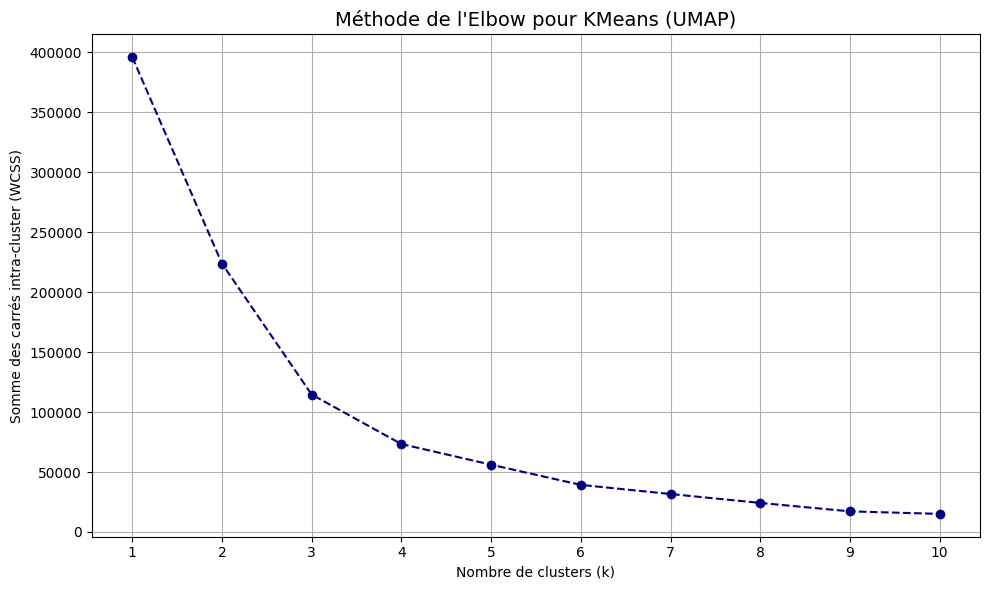

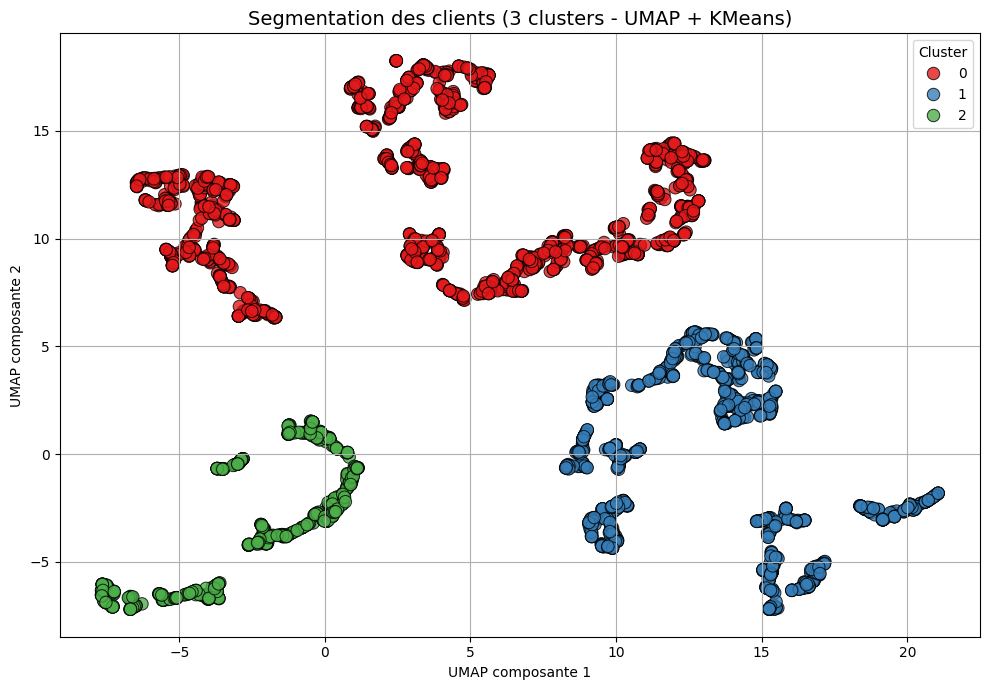

üìà Statistiques moyennes par cluster :
         Recency  Frequency  Monetary
Cluster                              
0          61.11       5.05   5580.55
1          40.01       8.29   9204.11
2         106.17       2.53   2807.77

üß† Interpr√©tation de la m√©thode de l‚ÄôElbow :
- La courbe de WCSS montre un point d'inflexion visible vers k=3, ce qui justifie ce choix.
- Ajouter plus de clusters n'apporte pas de gain significatif en r√©duction de variance intra-cluster.

üí° Interpr√©tation m√©tier des 3 segments :

Cluster 0 :
  - R√©cence moyenne : 61.11 jours
  - Fr√©quence moyenne : 5.05 transactions
  - Montant moyen : 5580.55 $
  ‚ûñ Ce cluster pourrait contenir des clients inactifs ou √† faible engagement.

Cluster 1 :
  - R√©cence moyenne : 40.01 jours
  - Fr√©quence moyenne : 8.29 transactions
  - Montant moyen : 9204.11 $
  ‚ûï Ce cluster repr√©sente probablement les meilleurs clients (actifs, fr√©quents et rentables).

Cluster 2 :
  - R√©cence moyenne : 106.17 jours
  - 

In [8]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# üß™ √âtape 1 : M√©thode de l‚ÄôElbow pour d√©terminer le nombre optimal de clusters
wcss = []
range_n_clusters = range(1, 11)
for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_umap)
    wcss.append(kmeans.inertia_)

# üìà Visualisation de la courbe de l‚ÄôElbow
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o', linestyle='--', color='navy')
plt.title("M√©thode de l'Elbow pour KMeans (UMAP)", fontsize=14)
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Somme des carr√©s intra-cluster (WCSS)")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.tight_layout()
plt.show()

# üìå Choix manuel de k = 3 (justifi√© plus bas)
best_k = 3
kmeans_model = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans_model.fit_predict(rfm_umap)

# üîç Cr√©ation d‚Äôun DataFrame avec les clusters
rfm_clustered = rfm_df.copy()
rfm_clustered['Cluster'] = kmeans_labels
rfm_clustered['X'] = rfm_umap[:, 0]
rfm_clustered['Y'] = rfm_umap[:, 1]

# üé® Visualisation des clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='X', y='Y',
    hue='Cluster',
    palette='Set1',
    data=rfm_clustered,
    s=80, alpha=0.8, edgecolor='k'
)
plt.title("Segmentation des clients (3 clusters - UMAP + KMeans)", fontsize=14)
plt.xlabel("UMAP composante 1")
plt.ylabel("UMAP composante 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# üìä Statistiques descriptives par cluster (Interpr√©tation m√©tier)
cluster_stats = rfm_clustered.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
print("üìà Statistiques moyennes par cluster :")
print(cluster_stats)

# üß† Interpr√©tation et justification
print("\nüß† Interpr√©tation de la m√©thode de l‚ÄôElbow :")
print("- La courbe de WCSS montre un point d'inflexion visible vers k=3, ce qui justifie ce choix.")
print("- Ajouter plus de clusters n'apporte pas de gain significatif en r√©duction de variance intra-cluster.")

print("\nüí° Interpr√©tation m√©tier des 3 segments :")
for cluster_id, row in cluster_stats.iterrows():
    print(f"\nCluster {cluster_id} :")
    print(f"  - R√©cence moyenne : {row['Recency']} jours")
    print(f"  - Fr√©quence moyenne : {row['Frequency']} transactions")
    print(f"  - Montant moyen : {row['Monetary']} $")
    if row['Monetary'] > rfm_clustered['Monetary'].mean():
        print("  ‚ûï Ce cluster repr√©sente probablement les meilleurs clients (actifs, fr√©quents et rentables).")
    elif row['Frequency'] < rfm_clustered['Frequency'].mean():
        print("  ‚ûñ Ce cluster pourrait contenir des clients inactifs ou √† faible engagement.")
    else:
        print("  ‚öñÔ∏è Ce cluster repr√©sente des clients interm√©diaires √† fid√©liser.")


# Notre synth√®se est la suivante
#üîπ Cluster 1 ‚Äì Clients Premium ou Fid√®les
R√©cence : 40.01 jours ‚Üí achats r√©cents

Fr√©quence : 8.29 transactions ‚Üí clients tr√®s actifs

Montant : 9204.11 $ ‚Üí panier moyen √©lev√©

#Interpr√©tation :

-Ce sont vos meilleurs clients. Ils ach√®tent souvent, ont d√©pens√© beaucoup, et leur dernier achat est r√©cent.

-Ce segment repr√©sente la client√®le la plus rentable.

#Recommandations :

-Fid√©lisation : offres VIP, programmes de loyaut√©, avant-premi√®res, cadeaux.

-Solliciter leur feedback ou les transformer en ambassadeurs.

#üî∏ Cluster 0 ‚Äì Clients Mod√©r√©ment Actifs
R√©cence : 61.11 jours ‚Üí achats assez r√©cents

Fr√©quence : 5.05 transactions ‚Üí activit√© mod√©r√©e

Montant : 5580.55 $ ‚Üí montant correct mais pas exceptionnel

#Interpr√©tation :

-Ce sont des clients potentiellement fid√®les mais moins engag√©s que ceux du Cluster 1.

-Ils pourraient devenir premium avec un bon suivi.

#Recommandations :

-Campagnes de relance (emails personnalis√©s, rappels).

-Offres incitatives (r√©duction au prochain achat, contenu exclusif).

#üîª Cluster 2 ‚Äì Clients Inactifs ou Perdus
R√©cence : 106.17 jours ‚Üí dernier achat lointain

Fr√©quence : 2.53 transactions ‚Üí peu d‚Äôinteractions

Montant : 2807.77 $ ‚Üí faible contribution

#Interpr√©tation :

-Ce cluster regroupe probablement des clients inactifs, d√©sengag√©s ou perdus.

-Ils repr√©sentent une valeur faible pour l‚Äôentreprise.

#Recommandations :

-Campagnes de r√©activation (offres limit√©es, emails √©motionnels).

-Comprendre les raisons de l‚Äôabandon (enqu√™te satisfaction, freins √† l‚Äôachat).

Si inefficace, les consid√©rer comme clients √† abandonner dans le ciblage marketing.